In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORK_DIR = 'C:\\Users\\thoma\\Box Sync\\00Professional\\01Research\\01_Projects\\moving_average\\'
DATA_DIR = WORK_DIR + 'data\\'
OUT_DIR = WORK_DIR + 'out\\'

SODIUM_CSV_PATH = DATA_DIR + 'sodium_12302016_01272017.csv'
POTASSIUM_CSV_PATH = DATA_DIR + 'potassium_12302016_01272017.csv'
CLORIDE_CSV_PATH = DATA_DIR + 'chloride_rs1_rs2_123016_012917.csv'
C02_CSV_PATH = DATA_DIR + 'bicarb_12302016_01272017.csv'
BUN_CSV_PATH = DATA_DIR + 'bun_12302016_01272017.csv'
CR_CSV_PATH = DATA_DIR + 'creatinine_12302016_01272017.csv'
GLUCOSE_CSV_PATH = DATA_DIR + 'glucose_12302016_01272017.csv'

In [13]:
parse_dates = ['Verified']
df = pd.read_csv(SODIUM_CSV_PATH, parse_dates=parse_dates)
df = df.sort_values(by='Verified')

In [5]:
df.head()

,Test,Component,Value,Verified,Method,Decision,Rule Summary
0,BASIC METABOLIC PANEL,SODIUM,137.0,2016-12-30 06:53:00,RS3,NaN,NaN
1,BASIC METABOLIC PANEL,SODIUM,143.0,2016-12-30 23:25:00,RS4,NaN,NaN
2,Comprehensive Metabolic Panel,Sodium,139.0,2016-12-31 00:23:00,RS4,NaN,NaN
3,BASIC METABOLIC PANEL,SODIUM,142.0,2016-12-31 05:30:00,RS2,NaN,NaN
4,Comprehensive Metabolic Panel,Sodium,139.0,2016-12-31 11:24:00,RS4,NaN,NaN


In [7]:
def df_to_series(df, method, qc=False, flags=False):
    
    if qc == False:
        # get the requested test and method and create a new DF
        df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'val'
    elif qc == True:
        df_ = df.loc[(df.Test == 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'qc'


    else:
        print "Set qc flag: true if you want qc, false if you want result values"
        
    if flags == False:
        # take just the data and the value columns
        df_ = df_[['Verified','Value']]
    else:
        df_ = df_[['Verified','Decision']]



    try:
        if len(df_) != 0:
            # save to csv
            df_.to_csv('tmp.csv'.format(test, method), index=False)

            # read csv back in as a series
            series = pd.Series.from_csv('tmp.csv'.format(test, method),header=0)
        else:
            print(test)
            sys.exit("in df_to_series(): df_ was null")
            
    except Exception, e:
        print e 
        
    return series


def simple_moving_average(Window, ValTimeSeries):
    """
    Create a simple moving averages TimeSeries
    In: 
    -> Moving averages window
    -> TimeSeries of values
    Out: TimeSeries of MovingAverages for each of the supplied TimeStamps
    """
    
    ma_rs1_series = ValTimeSeries.copy(deep=True)
    
    for i in range(len(ValTimeSeries)):
        if i == 0:
            continue
        elif i < Window:
            ma_rs1_series[i] = ValTimeSeries[:i].mean()
        else:
            start = i - Window
            ma_rs1_series[i] = ValTimeSeries[start:i].mean()

    return ma_rs1_series


def moving_average_flags(MaTimeSeries, UTL, LTL):
    """
    Create a time series of moving average flags:
    1 = "Out"
    0 = "In"
    
    In: TimeSeries of moving average values
    Out: TimeSeries of 0 or 1 digits representing in and out respectively. 
    """
    
    ma_flag_series = MaTimeSeries.copy(deep=True)
    for i in range(len(MaTimeSeries)):

        if LTL <= MaTimeSeries[i] <= UTL:
            # in = 0
            ma_flag_series[i] = 0
        else: 
            # out = 1
            ma_flag_series[i] = 1
    return ma_flag_series


def moving_avg_performance_metrics(ma_perf_model, moving_avg_flag_series, qc_flag_series):
    """
    Takes flags from Moving Averages and QC and compares to get performance metrics
    
    Input: MA and QC flag timeseries'
    Output: Class object of: TP, FP, TN, FN, Precision, Recall
    """

    rep_perf_data = ReplicatePerformanceModel()
    
    # set replicate parameters
    rep_perf_data.ma_window = WINDOW
    rep_perf_data.ma_utl = UTL
    rep_perf_data.ma_ltl = LTL
    rep_perf_data.ma_url = URefL
    rep_perf_data.ma_lrl = LRefL
    rep_perf_data.ma_window = WINDOW
    
    # set counts to zero
    rep_perf_data.true_positive = 0
    rep_perf_data.false_positive = 0
    rep_perf_data.true_negative = 0
    rep_perf_data.false_negative = 0

    # TODO: Need to seperate logic for high and low MA flags
    # loop through all MA flags and compare to QC flags
    for i in range(len(moving_avg_flag_series)):

        # instantiate the time stamp of i'th MA_flag
        rep_perf_data.ma_flag_ts = moving_avg_flag_series.index[i]
        

        # Check MovingAverage "In" flags relative to QC
        # i.e. True Negatives and False Negatives
        if moving_avg_flag_series[i] == 0:
            
            # instantiate startQcLookup variable with i'th MA_flag
            startQcLookup = moving_avg_flag_series.index[i]
            
            for qc in qc_flag_series[startQcLookup:]:

#                 print (startQcLookup, qc_flag_series.index[0])
                
                rep_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]

                if qc == 0:
                    # 'True Negative'
                    rep_perf_data.true_negative+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Negative'
                    rep_perf_data.false_negative+=1

        # Check MovingAverage "Out" flags relative to QC
        # i.e. True Positives and False Positives
        else:
            startQcLookup = moving_avg_flag_series.index[i]
            for qc in qc_flag_series[startQcLookup:]:
                
                # add QC_Flag TimeStamp to MovingAvgPerformanceMetrics
                rep_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]
                
                if qc == 1:
                    # 'True Positive'
                    rep_perf_data.true_positive+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Positive'
                    rep_perf_data.false_positive+=1
                break
    
    # Calculate difference in time between QC flag and MA flag
    rep_perf_data.ma_qc_diff_secs = rep_perf_data.calculate_timestamp_diff()
    rep_perf_data.recall = rep_perf_data.calculate_recall()
    rep_perf_data.precision = rep_perf_data.calculate_precision()
    rep_perf_data.number_of_ma_flags = rep_perf_data.calculate_number_of_flags()
    
    return rep_perf_data

def set_ma_experiment(component, method, ma_type, qc_rules):
    
    ma = MovingAvgExperimentModel()
    
    ma.component = component
    ma.component_method = method
    ma.ma_type = ma_type
    ma.qc_rules = qc_rules

    
    return ma

In [14]:
# Time series of all result values for a given method
rs1_val_series = df_to_series(df, 'RS1', qc=False, flags=False)
rs2_val_series = df_to_series(df, 'RS2', qc=False, flags=False)
rs3_val_series = df_to_series(df, 'RS3', qc=False, flags=False)
rs4_val_series = df_to_series(df, 'RS4', qc=False, flags=False)

In [27]:
rs1_val_series.index[0]

Timestamp('2016-12-30 00:42:00')

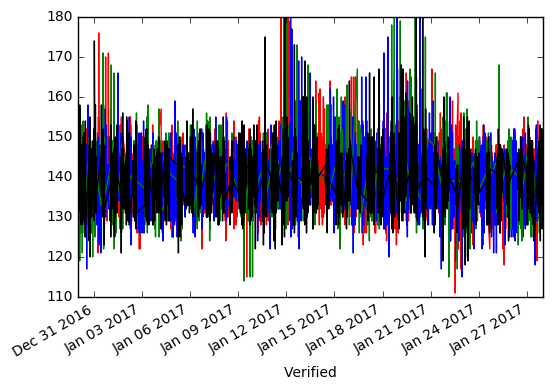

In [43]:
rs1_val_series.plot(color='red')
rs2_val_series.plot(color='blue')
rs3_val_series.plot(color='green')
rs4_val_series.plot(color='black')

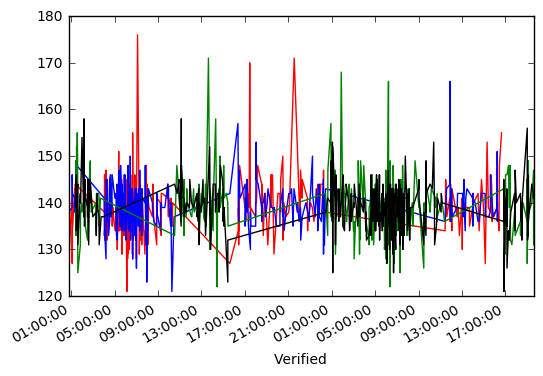

In [38]:
rs1_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='red')
rs2_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='blue')
rs3_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='green')
rs4_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='black')

In [48]:
rs1_ma_series = simple_moving_average(50, rs1_val_series)
rs2_ma_series = simple_moving_average(50, rs2_val_series)
rs3_ma_series = simple_moving_average(50, rs3_val_series)
rs4_ma_series = simple_moving_average(50, rs4_val_series)

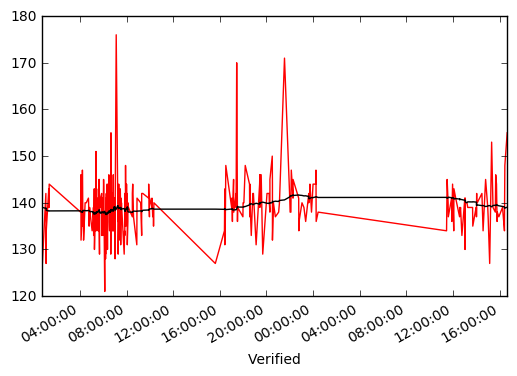

In [45]:
rs1_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='red')
rs1_ma_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='black')

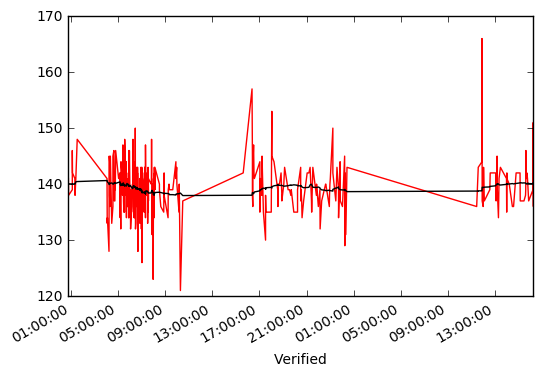

In [47]:
rs2_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='red')
rs2_ma_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='black')

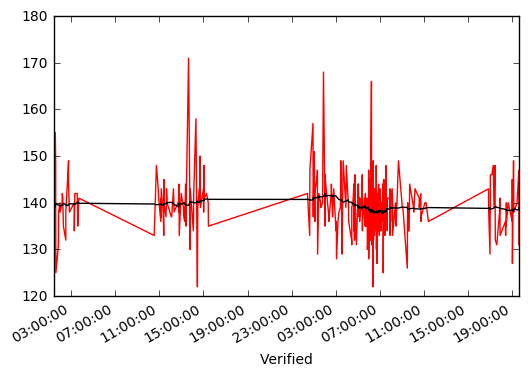

In [49]:
rs3_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='red')
rs3_ma_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='black')

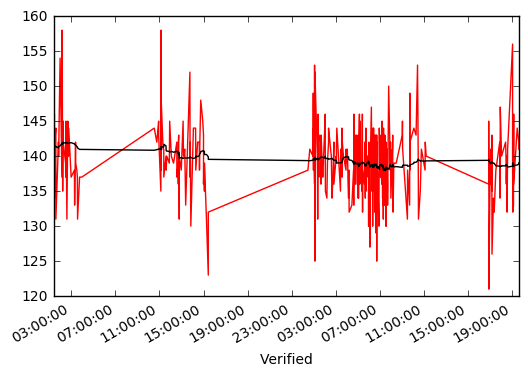

In [50]:
rs4_val_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='red')
rs4_ma_series['2016-12-31 00:42:00':'2017-01-1 19:49:00'].plot(color='black')

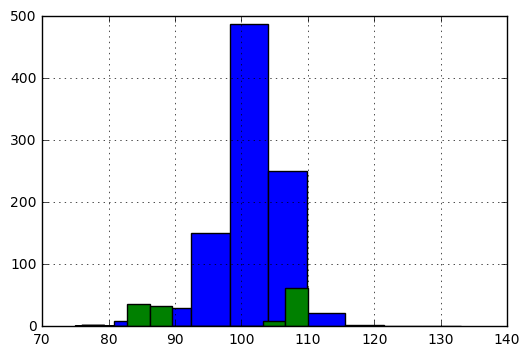

In [12]:
CMP_RS1_series = df_to_series(df, 'CMP', 'RS1')
QC_RS1_series = df_to_series(df, 'QC', 'RS1')
CMP_RS1_series.hist()
QC_RS1_series.hist()

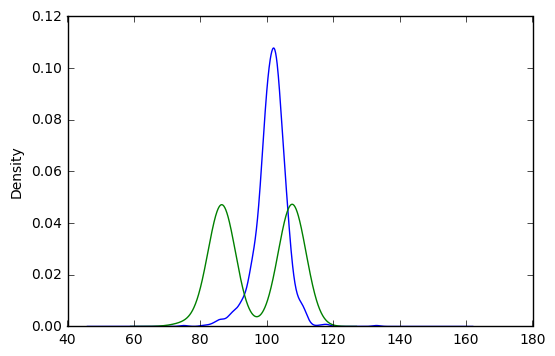

In [13]:
CMP_RS1_series.plot(kind='kde')
QC_RS1_series.plot(kind='kde')

In [14]:
normalCMP_RS1_series = CMP_RS1_series[(CMP_RS1_series <= 108) & (CMP_RS1_series >= 96)]
lowQC_RS1_series = QC_RS1_series[QC_RS1_series <= 95]
highQC_RS1_series = QC_RS1_series[QC_RS1_series >= 95]

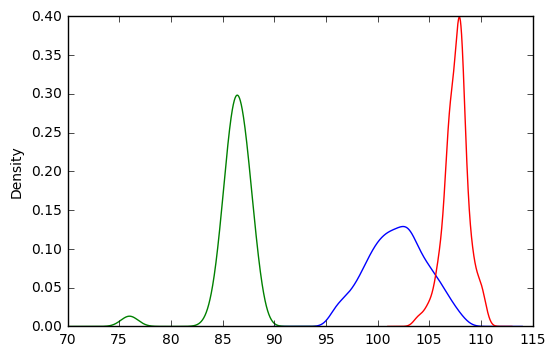

In [15]:
normalCMP_RS1_series.plot(kind='kde')
lowQC_RS1_series.plot(kind='kde')
highQC_RS1_series.plot(kind='kde')

In [16]:
highQC_RS1_series.describe()

count     71.000000
mean     107.619718
std        1.138498
min      104.000000
25%      107.000000
50%      108.000000
75%      108.000000
max      110.000000
Name: Value, dtype: float64

In [17]:
lowQC_RS1_series.describe()

count    72.000000
mean     86.152778
std       1.969197
min      76.000000
25%      86.000000
50%      86.000000
75%      87.000000
max      88.000000
Name: Value, dtype: float64

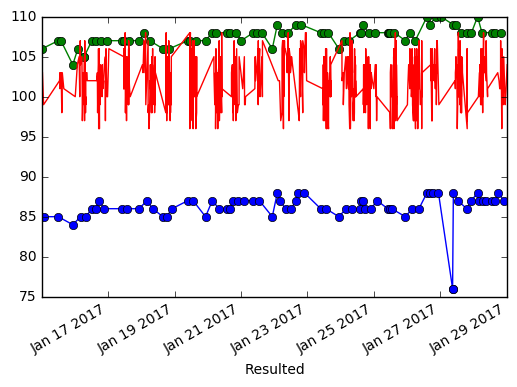

In [19]:
lowQC_RS1_series.plot(marker="o")
highQC_RS1_seriesplot(marker="o")
normalCMP_RS1_series.plot()

How do we know which QC to look at for any given period

In [66]:
df.Test.value_counts()

BMP             5027
CMP             1910
QC               298
ELECTROLYTES      77
Chloride           3
Name: Test, dtype: int64

In [65]:
len(CMP_RS1_series)

955

How do we know if QC is out with just the values?
Which QC is pre or post run
How can we identify 'runs' of specimens

In [22]:
highQC_RS1_series['2017-01-18 07:25:00':'2017-01-20 05:32:00']


Resulted
2017-01-18 15:32:00    106
2017-01-18 20:12:00    106
2017-01-19 09:27:00    107
2017-01-19 11:05:00    107
2017-01-19 15:09:00    107
2017-01-19 22:18:00    107
2017-01-20 03:12:00    108
Name: Value, dtype: int64

In [40]:
rolling.mean?

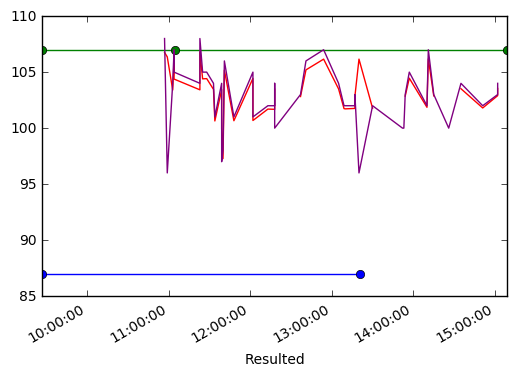

In [42]:
rolling = normalCMP_RS1_series.rolling(window=50)
moving_avg = rolling.mean()

lowQC_RS1_series['2017-01-19 09:27:00':'2017-01-19 15:09:00'].plot(marker="o")
highQC_RS1_series['2017-01-19 09:27:00':'2017-01-19 15:09:00'].plot(marker="o")
#CMP_RS1_series.plot()
moving_avg['2017-01-19 09:27:00':'2017-01-19 15:09:00'].plot(color='red')
normalCMP_RS1_series['2017-01-19 09:27:00':'2017-01-19 15:09:00'].plot(color='purple')

In [ ]:
plot